In [1]:
import requests as rq
from bs4 import BeautifulSoup
import pandas as pd 
import numpy as np
import time
import json
import concurrent.futures 
import re
import random
from lxml import etree
import pymongo
from tqdm import tqdm, trange
import jieba
import importlib
import matplotlib.pyplot as plt
import matplotlib
import sys
sys.path.append("CralwerProject") 

In [2]:
import CralwerProject
import CralwerProject.ip_pool as ip_pool
from CralwerProject.parsetools import TextParser, MongoDAO
from CralwerProject.playlistcrawler import PlaylistCrawler
from CralwerProject.songparser import SongParser

## 情感关键词歌单搜索

In [4]:
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.116 Safari/537.36'}

In [21]:
valid_ips = ip_pool.get_valid_ips('./data/valid_ips.json')

In [3]:
mongo_config_playlist = {
    'mongo_url': 'mongodb://192.168.206.100:27017/',
    'db_name': 'springTest',
    'collection_name': 'test_play_list'
}

mongo_config_added_playlist = {
    'mongo_url': 'mongodb://192.168.206.100:27017/',
    'db_name': 'springTest',
    'collection_name': 'added_play_list'
}

mongo_config_songdata = {
    'mongo_url': 'mongodb://192.168.206.100:27017/',
    'db_name': 'springTest',
    'collection_name': 'song_data'
}

In [4]:
# 歌单总集合
mongoDAO_playlist = MongoDAO(mongo_config_playlist)
# 新添加的歌单集合
mongoDAO_added_playlist = MongoDAO(mongo_config_added_playlist)
# 歌曲集合
mongoDAO_songdata = MongoDAO(mongo_config_songdata)

In [75]:
playlist_crawler = PlaylistCrawler('./data/valid_ips.json', mongoDAO_added_playlist)
song_parser = SongParser(mongoDAO_songdata)

In [29]:
def get_playlist_from_search(keywords, pages=10):
    playlist_ids = []
    with trange(page) as t:
        for i in range(1, pages+1):
            url = 'https://autumnfish.cn/search?keywords=' + keywords +'&limit=30&type=1000&offset=' + str(i * 30)
             # 随机抽取ip
            ip = random.choice(valid_ips)
            proxies = {}
            if ip.split(":")[0] == 'http':
                proxies = {
                    'http': ip
                }
            else:
                proxies = {
                    'https': ip
                }
            r = rq.get(url=url, headers=headers, proxies=proxies)
            search_dict = json.loads(r.text)
            # 从json中获取歌单id
            for item in search_dict['result']['playlists']:
                playlist_ids.append(item.get('id'))
            t.update(1)
    return playlist_ids

In [27]:
playlist_ids = get_playlist_from_search('恐怖')

In [28]:
len(playlist_ids)

300

In [36]:
type(playlist_ids[0])

int

In [44]:
def process_search_playlist_info(playlist_id_list):
    with trange(len(playlist_id_list)) as t:
        for playlist_id in playlist_id_list:
            # 查询是否已存在该歌单
            result = mongoDAO_playlist.count_documents({'_id':str(playlist_id)})
            if result == 0:
                playlist_crawler.process_playlist_info(str(playlist_id))
            t.update(1)
    # 将新添加的歌单数据同步添加到总集合中 
    added_list = mongoDAO_added_playlist.find()
    for playlist_dict in added_list:
        mongoDAO_playlist.insert_one(playlist_dict)

In [45]:
process_search_playlist_info(playlist_ids)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [02:27<00:00,  2.03it/s]


In [51]:
added_playlist_data = mongoDAO_added_playlist.find()

In [56]:
all_data = song_parser.song_data_concat(added_playlist_data)

  0%|                                                                                          | 0/277 [00:00<?, ?it/s]


In [60]:
all_data[3]

{'_id': 591922,
 'tags': ['轻音乐', '夜晚'],
 'play_lists': '纯音乐-恐怖、诡异、惊悚、压抑 网易云最恐怖的音乐 【日系/恐怖】阴森恐怖却好听的声音 恐怖 恐怖 恐怖惊悚｜孤独的时候听一听 恐怖 恐怖八音盒 蜜汁恐怖音乐 【空灵鬼乐】阴森恐怖 『诡异纯音』恐怖的BGM [阴暗恐怖]鬼畜天线宝宝3同人地图背景音东 恐怖主题音乐 恐怖/悬疑/压抑/紧张（2020.12.9更新） 诡异八音盒，恐怖小说的首选 恐怖故事 心脏病者勿入 恐怖诡异音乐（吓人专用） 恐怖，悬疑，紧张的纯音乐 诡异恐怖音乐 —— 氛围音效 【收集】BGM囤够了我们就做恐怖解谜游戏。 『恐怖纯音乐』『压抑』嘘，你看看你的身后'}

In [61]:
song_parser.process_all_song_data(all_data)

100%|███████████████████████████████████████████████████████████████████████████| 31720/31720 [01:42<00:00, 308.62it/s]


In [76]:
result = mongoDAO_songdata.find({'_id': 591922})

In [78]:
len(result[0]['tags'])

48

In [94]:
result[0]

{'_id': 484058025,
 'tags': ['流行',
  '网络歌曲',
  '综艺',
  '气势',
  '大气',
  '鼓点',
  '看书',
  '学习',
  '游戏',
  '蹦迪',
  'ACG',
  '温柔',
  '电音',
  '动感',
  '经典',
  '散步',
  'DJ',
  '嗨',
  '催泪',
  '治愈',
  '震撼',
  '热血',
  '浪漫',
  '刷题',
  '高能',
  '纯音乐',
  '青春',
  '日系',
  '放松',
  '古风',
  '史诗',
  '温暖',
  '英文',
  '励志',
  '运动',
  '动漫',
  '伤感',
  '战歌',
  '踩点',
  '欧美',
  'BGM',
  '燃',
  '电子',
  '节奏',
  '安静',
  '恋爱',
  '清晨',
  '街舞',
  '舒服',
  '欢快',
  '快乐',
  '优雅',
  '古典',
  '黑暗',
  '钢琴',
  '愉快',
  '伴奏',
  '国风',
  '感动',
  '丧',
  '清新',
  '日本',
  '轻音乐',
  '安眠',
  '恐怖',
  'rap',
  '自习',
  '诡异']}

In [79]:
result = mongoDAO_songdata.find({'tags':{'$in':['恐怖']}})

{ "_id" : 591922, "tags" : [ "浪漫", "影视原声", "ACG", "悲伤", "温柔", "动感", "钢琴", "静心", "节奏", "安静", "学习", "纯音乐", "刷题", "放松", "睡眠", "经典", "史诗", "战歌", "动漫", "BGM", "古典", "蹦迪", "自习", "轻音乐", "治愈", "看书", "伤感", "轻柔", "空灵", "唯美", "英文", "清新", "黑暗", "国风", "日系", "日本", "致郁", "欢快", "安眠", "震撼", "快乐", "感动", "恋爱", "催泪", "吉他", "伴奏", "恐怖", "诡异" ] }


In [6]:
mongoDAO_songdata.count_documents({'tags':{'$all':['恐怖', 'BGM', '惊悚']}})

30198

In [82]:
mongoDAO_songdata.count_documents({'tags':{'$in':['轻松']}})

197838

In [85]:
list_data = mongoDAO_playlist.find()

In [25]:
all_playlist = mongoDAO_playlist.find()

In [13]:
type(all_playlist[1])

dict

In [26]:
filename = 'all_playlist.json'
all_playlist_list = []

In [27]:
for playlist in all_playlist:
    all_playlist_list.append(playlist)

In [31]:
with open(filename, 'w', encoding='utf-8') as fw:       
    json.dump(all_playlist_list,fp=fw, ensure_ascii=False)

In [32]:
with open(filename, 'r', encoding='utf-8') as fr:
    my_playlist = json.load(fr)

In [37]:
my_playlist[6]

{'_id': '5180018018',
 'song_ids': [1491231632,
  1491237295,
  1491231647,
  1491231648,
  1491231659,
  1491231670,
  1491237338,
  1491237340,
  1491231684,
  1491237360,
  1491231712,
  1491237384,
  1491237390,
  1491231764,
  1489266004,
  1489267058,
  1489269048,
  1489269055,
  1489269059,
  1489269061,
  1489267095,
  1489267097,
  1489269066,
  1487528112,
  1487528118,
  1487528121,
  1487528129,
  1487527157,
  1487528134,
  1487528136,
  1487527161,
  1487527164,
  1487528141,
  1485814455,
  1485814456,
  1485815319,
  1485815320,
  1485815324,
  1485815327,
  1485814463,
  1485815332,
  1485814465,
  1485814466,
  1485815349,
  1485815352,
  1485815353,
  1484055473,
  1484054622,
  1484055543,
  1484054677,
  1482148824,
  1482146933,
  1482146943,
  1482148851,
  1481100312,
  1481101180,
  1481100310,
  1481100309,
  1481101179,
  1481100307,
  1481101177,
  1481101175,
  1480361519,
  1480361521,
  1480361525,
  1480360925,
  1480361528,
  1480360927,
  1480361529,


# 歌单用户与歌曲的对应

In [41]:
# 将新添加的歌单数据同步添加到总集合中 
added_list = mongoDAO_added_playlist.find()
for playlist_dict in added_list:
    mongoDAO_playlist.insert_one(playlist_dict)

E11000 duplicate key error collection: springTest.test_play_list index: _id_ dup key: { : "2317794065" }, full error: {'index': 0, 'code': 11000, 'errmsg': 'E11000 duplicate key error collection: springTest.test_play_list index: _id_ dup key: { : "2317794065" }'}
E11000 duplicate key error collection: springTest.test_play_list index: _id_ dup key: { : "818067578" }, full error: {'index': 0, 'code': 11000, 'errmsg': 'E11000 duplicate key error collection: springTest.test_play_list index: _id_ dup key: { : "818067578" }'}
E11000 duplicate key error collection: springTest.test_play_list index: _id_ dup key: { : "3211003706" }, full error: {'index': 0, 'code': 11000, 'errmsg': 'E11000 duplicate key error collection: springTest.test_play_list index: _id_ dup key: { : "3211003706" }'}
E11000 duplicate key error collection: springTest.test_play_list index: _id_ dup key: { : "2112176183" }, full error: {'index': 0, 'code': 11000, 'errmsg': 'E11000 duplicate key error collection: springTest.tes

In [43]:
result = mongoDAO_playlist.find({'_id':'2317794065'})

将歌单作为用户，其订阅数和播放数作为评分  
[歌单id, 歌曲id, 订阅数, 播放数]

In [38]:
# 模拟用户的评分
all_rattings = []

In [39]:
with trange(len(my_playlist)) as t:
    for playlist in my_playlist:
        for song_id in playlist.get('song_ids'):
            playlist_id = playlist.get('_id')
            subscribed_count = playlist.get('subscribedCount')
            play_count = playlist.get('playCount')
            all_rattings.append([playlist_id, song_id, subscribed_count, play_count])
        t.update(1)

100%|██████████████████████████████████████████████████████████████████████████| 64112/64112 [00:13<00:00, 4588.57it/s]


In [40]:
len(all_rattings)

10129381

In [46]:
all_rattings[0]

['4991155974', 28427734, 30512, 4992275]

In [47]:
all_rattings[8]

['4991155974', 28341143, 30512, 4992275]

In [48]:
with open('all_ratting.json', 'w', encoding='utf-8') as fw:       
    json.dump(all_rattings,fp=fw, ensure_ascii=False)

查询具有情感标签的歌曲，该查询的结果集合作为主数据

In [49]:
emotion_tags = ["治愈","安静","放松","震撼","欢快","清新","轻松","浪漫","伤感",
                "温柔","静心","快乐","舒心","悲伤","唯美","感动","催泪","宁静",
                "温暖","丧","欢乐","惊悚","致郁","愉快","诡异","恐怖","黑暗"]

In [53]:
result = mongoDAO_songdata.find({'tags':{'$in':emotion_tags}})

In [55]:
result.collection.find()

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  """Entry point for launching an IPython kernel.


1158210

In [59]:
result[49]

{'_id': 1416840107,
 'tags': ['综艺',
  '摇滚',
  '华语',
  '快乐',
  '恋爱',
  '青春',
  '浪漫',
  '放松',
  '嗨',
  '节奏',
  '清新',
  '温柔',
  '轻快',
  '漫步',
  'BGM',
  '惬意',
  '运动',
  '经典',
  '温暖',
  '治愈',
  '学习',
  '吉他',
  '爵士',
  '热血',
  '街舞',
  '励志',
  '丧',
  '优雅',
  '伤感',
  '欧美',
  '舒服',
  '轻柔',
  '欢乐',
  '看书',
  '鼓点',
  '古风',
  '游戏',
  '愉快']}

将获取的具有情感标签的歌曲导出成json

In [65]:
filename = 'big_data/all_emotion_songs.json'
all_emotion_songs = []

for song in result:
    all_emotion_songs.append(song)

with open(filename, 'w', encoding='utf-8') as fw:       
    json.dump(all_emotion_songs,fp=fw, ensure_ascii=False)

# 数据分析

## 数据收集与基本处理

In [5]:
def compulete_count_normalized(data, min_v, max_v, space, label='counts'):
    """
    统计一列中各个区间中数值的个数和其对应归一化的值
    data: 列的Series形式
    min_v: 区间最小值
    max_v: 区间最大值
    space： 区间间隔
    """
    # 处理最大、最小值
    if max_v % 10 > 0:
        max_v = max_v - (max_v % 10) + 10
    if min_v % 10 > 0:
        min_v = min_v - (min_v % 10)
    # 需要分段的区间
    sections = [x for x in range(min_v, max_v, space)]
    # 每个区间中的个数
    counts = []
    # 每个区间中的个数的比例即归一化
    counts_normalize = []
    for i in range(0, len(sections)-1):
        # 区间中个数统计
        part_count = data.value_counts(bins=[sections[i], sections[i+1]-1])
        part_count_normalize = data.value_counts(bins=[sections[i], sections[i+1]-1], normalize=True)
        counts.append(part_count)
        counts_normalize.append(part_count_normalize)
    # 合并Series
    result1 = pd.DataFrame(pd.concat([x for x in counts]))
    result2 = pd.DataFrame(pd.concat([x for x in counts_normalize]))
    # 对列的标签进行重命名
    result1.rename(columns={result1.columns[0]:label},inplace=True)
    result2.rename(columns={result2.columns[0]:'normalized'}, inplace=True)
    # 合并两个表
    result = pd.concat([result1, result2], axis=1)
    return result

读取需要的相关数据：所有的歌单信息、所有的具有情感标签的歌曲、歌单所在歌曲的订阅数和播放数

In [35]:
filename = 'big_data/all_playlist.json'
with open(filename, 'r', encoding='utf-8') as fr:       
    all_playlist = json.load(fp=fr)

In [36]:
filename = 'big_data/all_emotion_songs.json'
with open(filename, 'r', encoding='utf-8') as fr:       
    all_emotion_songs = json.load(fp=fr)

In [37]:
filename = 'big_data/all_ratting.json'
with open(filename, 'r', encoding='utf-8') as fr:       
    all_ratting = json.load(fp=fr)

In [38]:
all_emotion_songs_ids = []

In [39]:
for song in all_emotion_songs:
    all_emotion_songs_ids.append(song.get('_id'))

In [40]:
all_emotion_songs_ids[4]

574925512

In [41]:
all_ratting[987][1] in all_emotion_songs_ids

False

In [10]:
all_playlist[4]

{'_id': '2686463405',
 'song_ids': [1455717882,
  1456708452,
  1456637925,
  1454722927,
  1454674259,
  1454911616,
  1454670699,
  1454988189,
  1451170096,
  1453365684,
  1451749554,
  1450025246,
  1449559963,
  1450084723,
  1448027500,
  1448006342,
  1448216679,
  1446541217,
  1446912083,
  1443592120,
  1444564969,
  1442327038,
  1442825489,
  1443143862,
  1440968432,
  1441233819,
  1441272849,
  1443146229,
  1441296079,
  36668004,
  475279382,
  1424537185,
  421423806,
  1378085345,
  1336856777,
  490595991,
  1314154490,
  1428401120,
  1409296047,
  1417496128,
  186842,
  186513,
  30431367,
  30431376,
  30431364,
  474099732,
  1387615334,
  414118616,
  1346104327,
  1383927243,
  1410154047,
  1402551314],
 'tags_list': ['流行', '综艺', '华语'],
 'name': '我是唱作人2｜原唱歌单全收录',
 'subscribedCount': 39628,
 'playCount': 3605012}

In [10]:
df_ratting = []

In [11]:
with trange(len(all_playlist)) as t:
    for playlist in all_playlist:
        subscribedCount = playlist.get('subscribedCount')
        playCount = playlist.get('playCount')
        rate = (subscribedCount / playCount) * 100
        df_ratting.append([subscribedCount, playCount, rate])
        t.update(1)

100%|████████████████████████████████████████████████████████████████████████| 64112/64112 [00:00<00:00, 579029.21it/s]


In [12]:
df_ratting[3]

[20902, 1281887, 1.6305649405914873]

In [13]:
df_rate = pd.DataFrame(data=df_ratting, columns=['subscribedCount', 'playCount', 'rate'])

In [14]:
df_rate

,subscribedCount,playCount,rate
0,30512,4992275,0.611184
1,5494,409376,1.342043
2,14377,1205009,1.193103
3,20902,1281887,1.630565
4,39628,3605012,1.099247
...,...,...,...
64107,0,1493,0.000000
64108,4,809,0.494438
64109,50,3535,1.414427
64110,10,3316,0.301568


In [15]:
result_rate = compulete_count_normalized(df_rate.rate, 0, 100, 5)

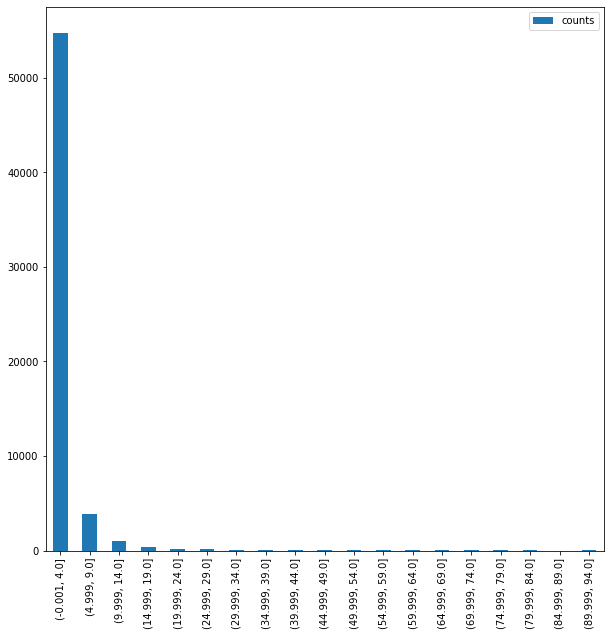

In [16]:
result_rate.plot.bar(y='counts', figsize=(10, 10), title='订阅数与播放数的比率分布直方图')

In [21]:
df_final_rate = df_rate[(df_rate['rate']<5)]

In [22]:
df_final_rate

,subscribedCount,playCount,rate
0,30512,4992275,0.611184
1,5494,409376,1.342043
2,14377,1205009,1.193103
3,20902,1281887,1.630565
4,39628,3605012,1.099247
...,...,...,...
64107,0,1493,0.000000
64108,4,809,0.494438
64109,50,3535,1.414427
64110,10,3316,0.301568


In [23]:
df_final_rate.rate.describe()

count    57403.000000
mean         1.761048
std          1.074568
min          0.000000
25%          0.970874
50%          1.549014
75%          2.370189
max          4.999818
Name: rate, dtype: float64

In [43]:
final_marking = []

根据数据分析结果，选择(订阅数 * 55 + 播放数)作为最终的计算结果

In [44]:
# 筛选
with trange(len(all_ratting)) as t:
    for item in all_ratting:
        if(item[1] in all_emotion_songs_ids):
            final_marking.append(item)
        t.update(1)

100%|██████████████████████████████████████████████████████████████████| 10129381/10129381 [11:40:25<00:00, 241.03it/s]


使用均方差归一化与sigmoid计算最终评分

In [46]:
len(final_marking)

3749386

In [43]:
final_marking[48]

['623978387', 353415, 5494, 409376]

In [45]:
with open('big_data/all_final_marking.json', 'w', encoding='utf-8') as fw:       
    json.dump(final_marking,fp=fw, ensure_ascii=False)

In [4]:
marking = pd.read_csv('big_data/selected_marking.csv')

In [6]:
marking.uid.max()

5388470916

In [7]:
marking.sid.max()

1808326466

## 针对评分处理

In [47]:
test_markings = []

In [48]:
with open('big_data/all_final_marking.json', 'r', encoding='utf-8') as fr:       
    test_markings = json.load(fp=fr)

In [49]:
len(test_markings)

3749386

In [50]:
test_markings[48]

['5074745281', 5057039, 14377, 1205009]

In [51]:
df_base = pd.DataFrame(test_markings, columns=['uid', 'sid', 'subscribedCount', 'playCount'])

计算总分数，为(订阅数*55+播放数)

In [52]:
df_base['total'] = df_base['subscribedCount'] * 55 + df_base['playCount']

计算均方差归一化

In [53]:
total_mean = df_base.total.mean()
total_std = df_base.total.std()

In [54]:
total_mean

1887794.9433653937

In [55]:
total_std

17109741.071033683

In [56]:
df_base['std_normal'] = (df_base['total'] - total_mean) / total_std

使用sigmoid进行数值映射

In [57]:
def Sigmoid(x):
    return 1. / (1 + np.exp(-x))

In [58]:
df_base['sigmoid_std'] = df_base['std_normal'].map(Sigmoid)

In [59]:
df_base['marking'] = df_base['sigmoid_std'].map(lambda x: round(x * 10, 2))

选取最终的评分

In [60]:
df_final_marking = df_base.loc[:, ['uid', 'sid', 'marking']]

In [61]:
df_final_marking.count()

uid        3749386
sid        3749386
marking    3749386
dtype: int64

In [62]:
def compulete_count_normalized(data, min_v, max_v, space, label='counts'):
    """
    统计一列中各个区间中数值的个数和其对应归一化的值
    data: 列的Series形式
    min_v: 区间最小值
    max_v: 区间最大值
    space： 区间间隔
    """
    # 处理最大、最小值
    if max_v % 10 > 0:
        max_v = max_v - (max_v % 10) + 10
    if min_v % 10 > 0:
        min_v = min_v - (min_v % 10)
    # 需要分段的区间
    sections = [x for x in range(min_v, max_v, space)]
    # 每个区间中的个数
    counts = []
    # 每个区间中的个数的比例即归一化
    counts_normalize = []
    for i in range(0, len(sections)-1):
        # 区间中个数统计
        part_count = data.value_counts(bins=[sections[i], sections[i+1]])
        part_count_normalize = data.value_counts(bins=[sections[i], sections[i+1]], normalize=True)
        counts.append(part_count)
        counts_normalize.append(part_count_normalize)
    # 合并Series
    result1 = pd.DataFrame(pd.concat([x for x in counts]))
    result2 = pd.DataFrame(pd.concat([x for x in counts_normalize]))
    # 对列的标签进行重命名
    result1.rename(columns={result1.columns[0]:label},inplace=True)
    result2.rename(columns={result2.columns[0]:'normalized'}, inplace=True)
    # 合并两个表
    result = pd.concat([result1, result2], axis=1)
    return result

In [63]:
df_result = compulete_count_normalized(df_final_marking.marking, 0, 11, 1)

In [64]:
df_result

,counts,normalized
"(3.999, 5.0]",3303002,0.880945
"(4.999, 6.0]",318612,0.084977
"(5.999, 7.0]",59481,0.015864
"(6.999, 8.0]",29563,0.007885
"(7.999, 9.0]",15928,0.004248
"(8.999, 10.0]",31674,0.008448
"(9.999, 11.0]",5848,0.001560


选择在平均水准之上的歌曲

In [65]:
df_selected_marking = df_final_marking[df_final_marking['marking'] >= 5]

In [66]:
df_selected_marking.count()

uid        454576
sid        454576
marking    454576
dtype: int64

In [31]:
int(time.time())

1611197410

In [67]:
df_selected_marking['timestamp'] = int(time.time())

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [68]:
df_selected_marking

,uid,sid,marking,timestamp
15,5074745281,28923579,5.02,1611720829
16,5074745281,29307041,5.02,1611720829
17,5074745281,451126971,5.02,1611720829
18,5074745281,558261233,5.02,1611720829
19,5074745281,509313150,5.02,1611720829
...,...,...,...,...
3691154,4418225,632452,5.29,1611720829
3691155,4418225,632425,5.29,1611720829
3691156,4418225,632806,5.29,1611720829
3691157,4418225,632815,5.29,1611720829


In [69]:
df_selected_marking.to_csv('big_data/selected_marking.csv', encoding='utf-8', index=False)

In [3]:
df_selected_marking = pd.read_csv('big_data/selected_marking.csv',names=['uid', 'sid', 'score', 'tp'])

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_selected_marking

,uid,sid,score,tp
0,uid,sid,marking,timestamp
1,5074745281,28923579,5.02,1611720829
2,5074745281,29307041,5.02,1611720829
3,5074745281,451126971,5.02,1611720829
4,5074745281,558261233,5.02,1611720829
...,...,...,...,...
454572,4418225,632452,5.29,1611720829
454573,4418225,632425,5.29,1611720829
454574,4418225,632806,5.29,1611720829
454575,4418225,632815,5.29,1611720829


In [6]:
len(set(df_selected_marking.uid.tolist()))

5981

In [70]:
filename = 'big_data/all_emotion_songs.json'
with open(filename, 'r', encoding='utf-8') as fr:       
    all_emotion_songs = json.load(fp=fr)

In [71]:
all_emotion_songs[2]

{'_id': 1306923998, 'tags': ['华语', '综艺', '摇滚', '温柔']}

In [40]:
str_tag = '|'.join(all_emotion_songs[2].get('tags'))

In [41]:
print(str_tag)

综艺|摇滚|华语|鼓点|温暖|爵士|浪漫


In [72]:
emotion_songs_list = []

In [73]:
with trange(len(all_emotion_songs)) as t:
    for song in all_emotion_songs:
        str_tags = '|'.join(song.get('tags'))
        song_id = song.get('_id')
        emotion_songs_list.append([song_id, str_tags])
        t.update(1)

100%|██████████████████████████████████████████████████████████████████████| 464552/464552 [00:00<00:00, 915033.49it/s]


In [74]:
emotion_songs_list[2]

[1306923998, '华语|综艺|摇滚|温柔']

In [75]:
df_songs = pd.DataFrame(emotion_songs_list, columns=['sid', 'tags'])

In [76]:
df_songs.count()

sid     464552
tags    464552
dtype: int64

In [77]:
df_songs.to_csv('big_data/songs.csv', encoding='utf-8', index=False)

In [48]:
df_songs.sid.max()

1808369467

# TF_IDF

In [8]:
from sklearn import feature_extraction  
from sklearn.feature_extraction.text import TfidfTransformer  
from sklearn.feature_extraction.text import CountVectorizer 

In [9]:
filename = 'big_data/all_emotion_songs.json'
with open(filename, 'r', encoding='utf-8') as fr:       
    all_emotion_songs = json.load(fp=fr)

In [10]:
emotion_songs_tags = []

In [11]:
all_emotion_songs[3]

{'_id': 1350149185, 'tags': ['综艺', '摇滚', '华语', '漫步', '恋爱', '青春', '温柔', '浪漫']}

In [12]:
with trange(len(all_emotion_songs)) as t:
    for song in all_emotion_songs:
        str_tags = ' '.join(song.get('tags'))
        emotion_songs_tags.append(str_tags)
        t.update(1)

100%|████████████████████████████████████████████████████████████████████| 1158210/1158210 [00:01<00:00, 842111.14it/s]


In [11]:
emotion_songs_tags[3]

'综艺 摇滚 华语 漫步 恋爱 青春 温柔 浪漫'

In [13]:
vectorizer=CountVectorizer()#该类会将文本中的词语转换为词频矩阵，矩阵元素a[i][j] 表示j词在i类文本下的词频  
transformer=TfidfTransformer()#该类会统计每个词语的tf-idf权值  

#第一个fit_transform是计算tf-idf，第二个fit_transform是将文本转为词频矩阵  
tfidf=transformer.fit_transform(vectorizer.fit_transform(emotion_songs_tags))

In [14]:
#获取词袋模型中的所有词语  
word=vectorizer.get_feature_names()

#将tf-idf矩阵抽取出来，元素a[i][j]表示j词在i类文本中的tf-idf权重  
weight=tfidf.toarray()

In [15]:
weight.shape

(1158210, 147)

In [ ]:


#打印每类文本的tf-idf词语权重，第一个for遍历所有文本，第二个for便利某一类文本下的词语权重  
for i in range(len(weight)):
    print("-------这里输出第" + str(i) + "类文本的词语tf-idf权重------") 
    for j in range(len(word)):  
        print(word[j] + ': ' + str(weight[i][j]))

-------这里输出第0类文本的词语tf-idf权重------
00后: 0.0
70后: 0.0
80后: 0.0
90后: 0.0
acg: 0.0
age: 0.0
bgm: 0.0
bossa: 0.0
dj: 0.0
ktv: 0.0
new: 0.0
nova: 0.0
rap: 0.0
soul: 0.0
下午茶: 0.0
世界音乐: 0.0
乡村: 0.0
优美: 0.0
优雅: 0.0
伤感: 0.0
伴奏: 0.0
催泪: 0.0
催眠: 0.0
儿童: 0.0
兴奋: 0.0
刷题: 0.0
动感: 0.0
动漫: 0.0
励志: 0.0
午休: 0.0
华语: 0.4542218002335664
古典: 0.0
古风: 0.0
另类: 0.0
史诗: 0.0
吉他: 0.0
后摇: 0.0
唯美: 0.0
器乐: 0.0
国风: 0.0
地铁: 0.0
夜晚: 0.0
大提琴: 0.0
大气: 0.0
孤独: 0.0
学习: 0.0
宁静: 0.0
安眠: 0.0
安静: 0.0
小提琴: 0.0
小语种: 0.0
工作: 0.0
影视原声: 0.0
快乐: 0.0
怀旧: 0.0
思念: 0.0
性感: 0.0
恋爱: 0.0
恐怖: 0.0
悲伤: 0.0
惊悚: 0.0
惬意: 0.0
愉快: 0.0
感动: 0.0
战歌: 0.0
拉丁: 0.0
搞笑: 0.0
摇滚: 0.544546970656213
放松: 0.0
散步: 0.0
旅行: 0.0
日本: 0.0
日系: 0.0
日语: 0.0
朋克: 0.0
校园: 0.0
榜单: 0.0
欢乐: 0.0
欢快: 0.0
欧美: 0.0
民族: 0.0
民谣: 0.0
气势: 0.0
治愈: 0.0
活泼: 0.0
流行: 0.0
浪漫: 0.28318812711151153
清新: 0.0
清晨: 0.0
温暖: 0.0
温柔: 0.0
游戏: 0.0
漫步: 0.0
激昂: 0.0
热血: 0.0
焦虑: 0.0
爵士: 0.2973945015805333
独立: 0.0
电子: 0.0
电子琴: 0.0
电音: 0.0
看书: 0.0
睡眠: 0.0
空灵: 0.0
粤语: 0.0
纪录片: 0.0
纯音乐: 0.0
经典: 0.0
综艺: 0.57315979

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



怀旧: 0.0
思念: 0.0
性感: 0.0
恋爱: 0.30301703932431817
恐怖: 0.0
悲伤: 0.0
惊悚: 0.0
惬意: 0.0
愉快: 0.0
感动: 0.0
战歌: 0.0
拉丁: 0.0
搞笑: 0.0
摇滚: 0.4017581371311378
放松: 0.22902521419206415
散步: 0.0
旅行: 0.0
日本: 0.0
日系: 0.0
日语: 0.0
朋克: 0.0
校园: 0.0
榜单: 0.0
欢乐: 0.0
欢快: 0.0
欧美: 0.0
民族: 0.0
民谣: 0.0
气势: 0.0
治愈: 0.0
活泼: 0.0
流行: 0.0
浪漫: 0.20893171854187897
清新: 0.23565823282571385
清晨: 0.0
温暖: 0.0
温柔: 0.20930731647952058
游戏: 0.0
漫步: 0.0
激昂: 0.0
热血: 0.0
焦虑: 0.0
爵士: 0.0
独立: 0.0
电子: 0.0
电子琴: 0.0
电音: 0.0
看书: 0.0
睡眠: 0.0
空灵: 0.0
粤语: 0.0
纪录片: 0.0
纯音乐: 0.0
经典: 0.0
综艺: 0.4228682244608849
网络歌曲: 0.0
翻唱: 0.0
自习: 0.0
致郁: 0.0
舒心: 0.0
舒服: 0.0
舒缓: 0.0
舞曲: 0.0
航拍: 0.0
节奏: 0.20270649727720455
英伦: 0.0
英文: 0.0
蓝调: 0.0
街舞: 0.0
诡异: 0.0
说唱: 0.0
踩点: 0.0
蹦迪: 0.0
轻快: 0.3028735885967971
轻松: 0.0
轻柔: 0.0
轻音乐: 0.0
运动: 0.0
邂逅: 0.0
酒吧: 0.0
金属: 0.0
钢琴: 0.0
阅读: 0.0
雷鬼: 0.0
震撼: 0.0
青春: 0.272509557749393
静心: 0.0
韩语: 0.0
音乐剧: 0.0
驾车: 0.0
高能: 0.0
黑暗: 0.0
鼓点: 0.0
-------这里输出第14类文本的词语tf-idf权重------
00后: 0.0
70后: 0.0
80后: 0.0
90后: 0.0
acg: 0.0
age: 0.0
bgm: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




清晨: 0.0
温暖: 0.18652742322876104
温柔: 0.13334167316476592
游戏: 0.0
漫步: 0.21359922351299382
激昂: 0.0
热血: 0.21586986691912802
焦虑: 0.0
爵士: 0.13977958948497954
独立: 0.0
电子: 0.0
电子琴: 0.0
电音: 0.0
看书: 0.0
睡眠: 0.0
空灵: 0.0
粤语: 0.0
纪录片: 0.0
纯音乐: 0.0
经典: 0.10909614274744703
综艺: 0.26939314652837376
网络歌曲: 0.0
翻唱: 0.0
自习: 0.0
致郁: 0.0
舒心: 0.0
舒服: 0.20185870926766825
舒缓: 0.0
舞曲: 0.0
航拍: 0.0
节奏: 0.12913654411577227
英伦: 0.0
英文: 0.0
蓝调: 0.0
街舞: 0.20493206837047187
诡异: 0.0
说唱: 0.0
踩点: 0.0
蹦迪: 0.0
轻快: 0.1929491607851433
轻松: 0.0
轻柔: 0.21592606175978857
轻音乐: 0.0
运动: 0.19301805236822328
邂逅: 0.0
酒吧: 0.0
金属: 0.0
钢琴: 0.0
阅读: 0.0
雷鬼: 0.0
震撼: 0.0
青春: 0.17360539992040747
静心: 0.0
韩语: 0.0
音乐剧: 0.0
驾车: 0.0
高能: 0.0
黑暗: 0.0
鼓点: 0.0
-------这里输出第27类文本的词语tf-idf权重------
00后: 0.0
70后: 0.0
80后: 0.0
90后: 0.0
acg: 0.0
age: 0.0
bgm: 0.10032278004709394
bossa: 0.0
dj: 0.0
ktv: 0.0
new: 0.0
nova: 0.0
rap: 0.0
soul: 0.0
下午茶: 0.0
世界音乐: 0.0
乡村: 0.0
优美: 0.0
优雅: 0.17696191742394646
伤感: 0.16007685103677552
伴奏: 0.0
催泪: 0.0
催眠: 0.0
儿童: 0.0
兴奋

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



优美: 0.0
优雅: 0.17176386321507436
伤感: 0.15537477636790045
伴奏: 0.0
催泪: 0.0
催眠: 0.0
儿童: 0.0
兴奋: 0.0
刷题: 0.0
动感: 0.0
动漫: 0.0
励志: 0.18333804688817829
午休: 0.0
华语: 0.20721957767271462
古典: 0.0
古风: 0.0
另类: 0.0
史诗: 0.0
吉他: 0.14391075137072568
后摇: 0.0
唯美: 0.0
器乐: 0.0
国风: 0.0
地铁: 0.0
夜晚: 0.0
大提琴: 0.0
大气: 0.0
孤独: 0.0
学习: 0.13272157149286615
宁静: 0.0
安眠: 0.0
安静: 0.0
小提琴: 0.0
小语种: 0.0
工作: 0.0
影视原声: 0.0
快乐: 0.14251098359908318
怀旧: 0.0
思念: 0.0
性感: 0.0
恋爱: 0.18737020213773486
恐怖: 0.0
悲伤: 0.0
惊悚: 0.0
惬意: 0.21169198500607658
愉快: 0.0
感动: 0.0
战歌: 0.0
拉丁: 0.0
搞笑: 0.0
摇滚: 0.24842663479452656
放松: 0.14161745086511773
散步: 0.0
旅行: 0.0
日本: 0.0
日系: 0.0
日语: 0.0
朋克: 0.0
校园: 0.0
榜单: 0.0
欢乐: 0.2065111976973529
欢快: 0.0
欧美: 0.1263065140481061
民族: 0.0
民谣: 0.0
气势: 0.0
治愈: 0.12254728639768878
活泼: 0.0
流行: 0.0
浪漫: 0.12919266330193616
清新: 0.14571896952869398
清晨: 0.0
温暖: 0.18104839321202862
温柔: 0.12942491381053908
游戏: 0.0
漫步: 0.20732499028272433
激昂: 0.0
热血: 0.2095289361321982
焦虑: 0.0
爵士: 0.13567372369185443
独立: 0.0
电子: 0.0
电子琴: 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



纯音乐: 0.0
经典: 0.10040202130367895
综艺: 0.24792458977601964
网络歌曲: 0.0
翻唱: 0.0
自习: 0.0
致郁: 0.0
舒心: 0.0
舒服: 0.1857721264732784
舒缓: 0.0
舞曲: 0.0
航拍: 0.0
节奏: 0.11884535719480012
英伦: 0.0
英文: 0.0
蓝调: 0.0
街舞: 0.188600562551242
诡异: 0.0
说唱: 0.0
踩点: 0.0
蹦迪: 0.0
轻快: 0.1775726003120332
轻松: 0.0
轻柔: 0.19871841943131496
轻音乐: 0.0
运动: 0.17763600176709707
邂逅: 0.0
酒吧: 0.0
金属: 0.0
钢琴: 0.0
阅读: 0.0
雷鬼: 0.0
震撼: 0.0
青春: 0.1597703880474761
静心: 0.0
韩语: 0.0
音乐剧: 0.0
驾车: 0.0
高能: 0.0
黑暗: 0.0
鼓点: 0.16173901611028624
-------这里输出第67类文本的词语tf-idf权重------
00后: 0.0
70后: 0.0
80后: 0.0
90后: 0.0
acg: 0.0
age: 0.0
bgm: 0.09149705506170637
bossa: 0.0
dj: 0.0
ktv: 0.0
new: 0.0
nova: 0.0
rap: 0.0
soul: 0.0
下午茶: 0.0
世界音乐: 0.0
乡村: 0.0
优美: 0.0
优雅: 0.1613939954092509
伤感: 0.14599436385774966
伴奏: 0.0
催泪: 0.0
催眠: 0.0
儿童: 0.0
兴奋: 0.0
刷题: 0.0
动感: 0.0
动漫: 0.0
励志: 0.17226941304156007
午休: 0.0
华语: 0.1947091486044423
古典: 0.0
古风: 0.14348776227203125
另类: 0.0
史诗: 0.0
吉他: 0.13522245431209162
后摇: 0.0
唯美: 0.0
器乐: 0.0
国风: 0.0
地铁: 0.0
夜晚: 0.0
大提琴: 0.0
大气

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




儿童: 0.0
兴奋: 0.0
刷题: 0.0
动感: 0.0
动漫: 0.0
励志: 0.17226941304156007
午休: 0.0
华语: 0.1947091486044423
古典: 0.0
古风: 0.14348776227203125
另类: 0.0
史诗: 0.0
吉他: 0.13522245431209162
后摇: 0.0
唯美: 0.0
器乐: 0.0
国风: 0.0
地铁: 0.0
夜晚: 0.0
大提琴: 0.0
大气: 0.0
孤独: 0.0
学习: 0.12470879671241755
宁静: 0.0
安眠: 0.0
安静: 0.13384763212915088
小提琴: 0.0
小语种: 0.0
工作: 0.0
影视原声: 0.0
快乐: 0.13390719446009583
怀旧: 0.0
思念: 0.0
性感: 0.0
恋爱: 0.1760581357312766
恐怖: 0.0
悲伤: 0.0
惊悚: 0.0
惬意: 0.19891154412069295
愉快: 0.21216574142485822
感动: 0.0
战歌: 0.0
拉丁: 0.0
搞笑: 0.0
摇滚: 0.2334284197215511
放松: 0.13306760681188917
散步: 0.0
旅行: 0.0
日本: 0.0
日系: 0.0
日语: 0.0
朋克: 0.0
校园: 0.0
榜单: 0.0
欢乐: 0.19404353552173947
欢快: 0.0
欧美: 0.11868103433906392
民族: 0.0
民谣: 0.0
气势: 0.0
治愈: 0.11514876184124476
活泼: 0.0
流行: 0.0
浪漫: 0.12139293864014383
清新: 0.13692150525111618
清晨: 0.0
温暖: 0.17011799220145846
温柔: 0.12161116753193536
游戏: 0.13070747702493693
漫步: 0.19480819715853007
激昂: 0.0
热血: 0.19687908459465409
焦虑: 0.0
爵士: 0.1274827191751088
独立: 0.0
电子: 0.1284448474426249
电子琴: 0.

# 歌曲标签优化

In [3]:
filename = 'big_data/all_song_data.json'
with open(filename, 'r', encoding='utf-8') as fr:       
    all_song_data = json.load(fp=fr)

In [5]:
len(all_song_data)

1973839

In [9]:
all_song_data[54634]

{'song_id': 551722370,
 'tags': ['韩语', '说唱', '综艺'],
 'play_lists': 'IM JM WDP Music 【Show Me The Money 1-9季】歌曲大全 Show Me The Money'}

In [3]:
mongo_config_all_songdata = {
    'mongo_url': 'mongodb://192.168.206.100:27017/',
    'db_name': 'springTest',
    'collection_name': 'all_song_data'
}
mongo_config_playlist = {
    'mongo_url': 'mongodb://192.168.206.100:27017/',
    'db_name': 'springTest',
    'collection_name': 'all_playlist'
}

In [4]:
# 歌单总集合
mongoDAO_all_songdata = MongoDAO(mongo_config_all_songdata)

mongoDAO_all_playlist = MongoDAO(mongo_config_playlist)

In [12]:
for song in all_song_data:
    mongoDAO_all_songdata.insert_one(song)

In [14]:
result = mongoDAO_all_songdata.find({'song_id':1376142151})

In [15]:
result[0]

{'_id': ObjectId('600e69a45ace1518405e6dab'),
 'song_id': 1376142151,
 'tags': ['流行', '放松', '综艺'],
 'play_lists': '我将玫瑰藏于身后 时刻期盼着与你赴约 2020重庆欢乐谷之行 Han**** 任何关系你想淡就散 千万不要跟双子座在一起 常听的歌在这里 心有不甘，无以为继 我就再吃一口意面 我想拥抱你，伸手在风里 ▄︻┻┳═一MuHabbaT 同 流 合 「污」 男人贵在稳重c Sounderoysters (๑• . •๑) 有故事的人听有故事的歌。。 开始于朋友验证 结束于红色感叹号 嗨唱转起来歌曲原曲合集 溯 Reverse (Live) 2019年度最热新歌‖中文·流行·古风 是谁·想成为谁 我爱ci巧乐兹(*∩_∩*) 《明日之子乐团季》第四季 『热搜榜』那些能上热搜的歌（每日更新） 〖网易云热歌〗热评10w＋（持续更新） 我也希望被热爱 All people like the music welcome The best songs 儿歌三百首 | 文化输出要从小培养 白首流行 · 00后麦霸速成宝典 Hit song 写作业必听歌曲ﾉ☀ 作文/歌词／励志／学习 所有的好运气，都在遇到GLY之后如约而至 来自孙孙孙伟的歌单 每日必备甜甜咸咸 「人間地獄」网易云歌曲合档 excellent 【治愈男声】让你爱上我要多久..... 流行歌曲/古风/丧系/治愈/原耽/学习 适合写作业听的歌 NV-XQF-paraboy 中考励志 奋斗的岁月愿我们无悔 祝万事胜意 Last Christmas 青少年励志歌曲锦集 节奏感要好（中） 原来年少情深也可以走到相看两厌 好好加油，金榜题名！ 本人写作业歌单 2019年最火的歌 日系☆网红治愈歌曲 网瘾少年青衫吖 溫 柔 的 人 最 可 愛 00后流行歌曲 DJ偏爱（咚鼓版） [幸福了然后呢]华语精选歌旁 向着风 拥抱彩虹，勇敢的向前走♥ 这些华语单曲竟然评论过十万，你敢相信？ 愿你前程似锦再无波澜. 超好听的中文歌曲 迪迦也能保护你是吗？ Reverse 追溯 ZHANGXURUI. 付费vip专享歌 星星不会长大嗷~ 治疗系 一听就会迷上的旋律 『自用学习BGM』|那就顶峰见 （热榜循环）行走在排行榜的小

In [16]:
result_1 = mongoDAO_all_songdata.find({'song_id':529823971})

In [17]:
result_1[0]

{'_id': ObjectId('600e69a45ace1518405e6df3'),
 'song_id': 529823971,
 'tags': ['流行', '放松', '综艺'],
 'play_lists': "Part'.2 一名双子座男生喜欢听的歌 想听歌的江川-_ 我将玫瑰藏于身后 时刻期盼着与你赴约 2020重庆欢乐谷之行 他只是经过你却傻傻的不想错过. 我就再吃一口意面 ▄︻┻┳═一MuHabbaT Sounderoysters 那些评论过十万的惊为天人 蹦disco dancing 陪你跨年的人你等到了吗？ 【视频剪辑酷炫BGM】 Spanish und Greek 来电铃声大全❤️（持续更新） 敢爱敢恨的双子座歌单. “个人宝藏音乐屋” 〖网易云热歌〗热评10w＋（持续更新） 儿砸，我是你爸爸！ 五彩缤纷的自己 Swaggy P 应该会喜欢 夫人你马甲又掉了--秦苒程隽 Create Song List 坤坤给ikun们的宠溺 适合写作业听的歌 刘耀文歌单（持续更新） 2020年度最热新歌 『小鬼王琳凯』专属歌单 琳要搞鬼❤️ “想陪你看月落重生灯再红” 这些华语单曲竟然评论过十万，你敢相信？ 『偶像练习生』参赛曲目——百分之九.♡ Justin黄明昊歌曲合集 （持更中） 分数线不同看到的夕阳都不一样丨刷题BGM 下雨时的你 就别在拥抱我 有痕的游戏歌单 又好听却不知道歌名。 A playlist full of joy . 「网易云音乐」热评10w+ 十万(持续更新) 十万热评/持续收录 [网易云那些评论超过十万的好歌~] 云音乐热歌榜-上榜歌曲全收录 网易云热评10w+的热歌 云音乐·严选评论过十万的热歌 追梦时代\xa0承包你的心动时刻 失去找的回来吗？ 2018上半年最热单曲，你听过几首？ 乐华七子NEX7 2018上半年最热新歌TOP50 【Nine Percent音乐合集】♡ 那些百听不厌的华语热歌 网易云10w+ 『偶 像 练 习 生·Eiei』｜原唱 『 2018年华语热门新歌 』 网易云评论过十万热评10w+ 2018年度最热新歌TOP100 2018年一月最热新歌TOP50 2018年度最热新歌 揉揉酱会拉的歌歌单 国家级蹦迪歌单. i wanna get love ♡ 毕雯珺先生的歌单啊♪ 蔡徐坤应援曲！含CP哦！

In [18]:
filename = 'big_data/all_playlist.json'
with open(filename, 'r', encoding='utf-8') as fr:       
    all_playlist = json.load(fp=fr)

In [23]:
with trange(len(all_playlist)) as t:
    for playlist in all_playlist:
        mongoDAO_all_playlist.insert_one(playlist)
        t.update(1)

100%|██████████████████████████████████████████████████████████████████████████| 64112/64112 [00:46<00:00, 1387.19it/s]


In [30]:
len(all_playlist)

64112

In [31]:
all_playlist[64110]

{'_id': '2186214689',
 'song_ids': [1410339379,
  407889965,
  470547650,
  1331503206,
  1344440225,
  427142868,
  1401671455,
  1353027224,
  1445109428,
  1306497271,
  562957019,
  1445869911,
  1357807377,
  1351832505,
  36025856,
  36024903,
  400876320,
  1344438011,
  1384056828,
  483024225,
  1380228195,
  521657090,
  1405069977,
  1396930659,
  532904684,
  440403867,
  19264098,
  28099920,
  1338490248,
  444267630,
  439121233,
  1380064333,
  1393008523,
  2009830,
  33504169,
  1384265008,
  1356795124,
  463160100,
  526099041,
  33418566,
  482999243,
  437292531,
  2310358,
  1294729061,
  437909145,
  1367368353,
  1832647,
  482246882,
  35807063,
  36102468,
  31010566,
  28864241,
  31081299,
  507532195,
  1343492095,
  494410635,
  34033985,
  31090820,
  31421324,
  17214006,
  27845051,
  485918020,
  1339550105,
  1345938424,
  1330020822,
  559902519,
  34690628,
  458725740,
  32019002,
  32526089,
  29422008,
  28662037,
  567145750,
  1302290019,
  44

In [24]:
result_playlist = mongoDAO_all_playlist.find({'tags':{'$in':['恐怖', '黑暗']}})

In [29]:
result_playlist.count()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  """Entry point for launching an IPython kernel.


0

In [32]:
all_songs_dict = {}

In [34]:
with trange(len(all_playlist)) as t:
    for item in all_playlist:
        song_ids = item.get("song_ids")
        tags_list = item.get("tags_list")
        name = item.get("name")
        for song_id in song_ids:
            song_dict = {}
            song_dict['_id'] = song_id
            song_dict['tags'] = tags_list
            song_dict['play_lists'] = name
            # 该bgm的id已经存在
            if song_id in all_songs_dict.keys():
                # 将新的内容加入原数据中 
                orgin_tags = all_songs_dict[song_id].get('tags')
                orgin_play_lists = all_songs_dict[song_id].get('play_lists')
                # 合并标签列表
                new_tags = list(set(orgin_tags + tags_list))
                new_play_lists = name + ' ' + orgin_play_lists
                # 更新字典数据
                all_songs_dict[song_id]['tags'] = orgin_tags
                all_songs_dict[song_id]['play_lists'] = new_play_lists
            # 加入bgm列表
            else:
                all_songs_dict[song_id] = song_dict
        t.update(1)

100%|██████████████████████████████████████████████████████████████████████████| 64112/64112 [00:25<00:00, 2512.12it/s]


In [35]:
all_song_data = []

In [36]:
with trange(len(all_songs_dict.values())) as t:
    for item in all_songs_dict.values():
        all_song_data.append(item)
        t.update(1)

100%|███████████████████████████████████████████████████████████████████| 1976892/1976892 [00:01<00:00, 1807686.06it/s]


In [37]:
all_song_data[34]

{'_id': 34509586,
 'tags': ['综艺', '摇滚', '华语'],
 'play_lists': '“享受爱和孤独。” Everyday 后摇 后朋克 迷幻摇滚 Sounderoysters 「乐队的夏天」第二季收录 宝藏乐队｜一群神仙喝了假酒 ㅤ上 野 公 園 国摇/白噪/另类 国摇｜我能看到你的眼含着泪 假日枯燥：只有摇滚才是我的解药 仇Pai工作室 乐队的夏天第二季 | 参赛乐队 民谣摇滚聚集地 沙灘裡的碎石和人生 昨夜西风凋碧树 「但我爱你」霓虹花园 她爱上了摇滚乐 因为你给的嬉笑太盛，于是没人欣赏你的认真 摇滚｜统统杀死我吧 【indie/Alt pop】 乐队：让这个夏天更加夏天~~ In mind Chesterbox 收集一些摇滚朋克金属钉鞋后摇迷幻 很骚的部分国摇和indie 无副作用荷尔蒙 如果你也爱听那我们就是好朋友 一起听摇滚吧！ 看见兴奋到死的东西 阿希听的乐队歌 朋克少女不止朋克Side A 为什么是该死的水瓶座 嘿 你要跳舞吗！ 来自神秘东方的独立摇滚朋克民谣乐队 生命因你而火热 迟 早 会 有 狗 的 可能小清新是这样变成燥狗的 【节奏&朋克&国语摇滚】²³³³³ 乐队的夏天第二季 乐队歌单 霓虹甜心｜暧昧〃梦幻〃独立〃摇滚〃 独立摇滚/朋克 /钉鞋/后朋/后摇 中国摇滚依然前行 杂食摇滚 | 开车不要听 无望生活里点起垃圾小众 摇滚纠察小队长 中国独立音乐的时代 「摇滚」经典不朽 永远不知好歹 永远声名狼藉 永 存 想 象 〖 内地港台小众乐队出众歌曲〗 跟我在Livehouse里跳舞吧 血液中的 兴奋剂 遇瑜余愈愚(超自然) 乐队的夏天第二季阵容 给你们 摇滚拾忆路上的歌 「中国摇滚」 众生皆苦，唯有自渡。 「乐队的夏天第二季」参赛乐队代表作 乐队的夏天『第二季』全 【没有未来】朋克 摇滚 后朋 独立音乐 广州现场独立音乐共享歌单 永远年轻 永远热泪盈眶 英伦摇滚丨Britpop 来一场夏天的party |国内乐队 要去的摇滚现场·摇滚精选 摇滚 | 没有理想的人不伤心 我开始不摇滚了 不正常人类研究中心 要一起去，环游科尔马吗 一起逛樱花市集叭 一首民谣，一杯酒；一个破包，路上走。 那些好听的音乐 日 常 的 鏡 頭 线上音乐节｜年轻的巨人啊，奔跑吧 保护姑娘，贯彻落实！ 新的民谣，旧的远方 胡子哥的潮

In [38]:
with trange(len(all_song_data)) as t:
    for song in all_song_data:
        mongoDAO_all_songdata.insert_one(song)
        t.update(1)

100%|██████████████████████████████████████████████████████████████████████| 1976892/1976892 [19:10<00:00, 1717.74it/s]


## 处理歌单文本

In [14]:
filename = 'data/tag_words.json'
with open(filename, 'r', encoding='utf-8') as fr:       
    all_tags = json.load(fp=fr)

In [15]:
all_tags = list(set(all_tags))

In [17]:
len(all_tags)

95

In [8]:
emotion_tags = ["治愈","安静","放松","震撼","欢快","清新","轻松","浪漫","伤感",
                "温柔","静心","快乐","舒心","悲伤","唯美","感动","催泪","宁静","孤独",
                "温暖","丧","欢乐","惊悚","致郁","愉快","诡异","恐怖","黑暗"]
emotion_tags = list(set(emotion_tags))

In [11]:
emotion_tags

['丧',
 '伤感',
 '惊悚',
 '轻松',
 '治愈',
 '悲伤',
 '诡异',
 '唯美',
 '快乐',
 '安静',
 '浪漫',
 '舒心',
 '欢快',
 '温柔',
 '孤独',
 '清新',
 '愉快',
 '恐怖',
 '静心',
 '黑暗',
 '致郁',
 '震撼',
 '欢乐',
 '感动',
 '放松',
 '催泪',
 '宁静',
 '温暖']

In [6]:
result_all_song = mongoDAO_all_songdata.find()

In [8]:
result_all_song.collection.count()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  """Entry point for launching an IPython kernel.


1976892

In [9]:
text_parser = TextParser()

In [84]:
test = result_all_song[56741]

In [85]:
test

{'_id': 431791310,
 'tags': ['舞曲', '伤感', '综艺'],
 'play_lists': "一定要和喜欢的人一起看日出 橘子树上的橘子熟了 “日常的镜头” 零點至四點觀察人類 2020年网易云氧气耳机VIP专属 日推温柔中文歌 希望我们永远有话聊，并且永远聊不腻 我十几岁 好累（成熟稳重上进） 如果我喜欢你我就每天给你推歌 累了就来听喜欢的歌儿 说不定明天她就来了 一切都会慢慢慢慢慢慢慢慢好起来的 今晚睡个安稳觉 给未来男朋友的歌单 相爱这词 太漂亮也太心酸 有没有一首安静时刻特别想她的歌 【华语】温柔男声 明明想改名叫暗暗了 【男声】温柔始终是你的代名词 ''我唱这么走心 却走不进你心里'' 有些男声翻唱一直想和你听(部分原唱) 优质男生翻唱 烟嗓 惬意 我们就这样错过 头也没回（好听翻唱） 思念在所難免.（懒吴日常听歌） 慵懒男声华语‖酥化你的内心的烦躁~ 她是你的苦口良药 好好吃饭 不要生病 一些ktv小众人爱唱 从此以后山河永寂 算不出来日方长 一个天秤座的听歌列表. 秋天晚上的月亮. 那些已注销账号的最后痕迹 那些好听到爆的华语流行新歌 以 丧 治 丧 “感谢遇见你” 我肯定在几百年前就说过爱你 (⑉°з°)-♡ 張搭耶 的歌单 攒了一大堆好听的歌想和你听 不管什么时候听都会想知道名字的歌曲 周杰倫`經典歌曲 暗恋心事丨你内心的那些小九九 那些适合在阳光下喝茶睡觉时听的音乐 「宝藏男孩」精选 | 男友音 开车和健身专用 秋秋の私藏歌单大赏「小红书」 ❤️从你的全世界路过 「走心华语」甜到忧伤。 2020伤感歌曲 听完就要早早睡觉呐 一个温柔的人. 摩羯座女孩的心事 烟嗓 温柔男生翻唱 叶航成同款歌单！ 我嘴笨 说不出来的爱可以和你做出来吗？ 男生女生吉他翻唱集合遇到喜欢的歌能下就下 前程不想想钗裙，从此不敢看观音 一个射手座的听歌列表 烟酒嗓与民谣『小众/冷门』 所爱之人在路上 白羊座歌單裡有秘密 总之岁月漫长，然而喜欢你值得等待♡ 本猪猪甜甜的歌单 睡觉歌单（偏温柔） 夜深了，你还好吗 【孤独伤感】能离开你的人 真的不缺你 晚安 | 醒来后再胡搅蛮缠的一切都亮了起来 夜又深了'￡你是不是又睡不着了 一个死要面子的狮子座歌单 春娇与志明-街道办 一起边听歌边做作业 12月31日早安 关于我们 皆是遗憾 想你的时候可以给你

In [86]:
rz = text_parser.clean_zh_text(test.get('play_lists'))
rz = text_parser.seg_sentence(rz)
rz

'一定 要 喜欢 一起 日出   橘子 树上 橘子 熟   日常 镜头   零點 四點 觀察人類   2020 年 网易 云 氧气 耳机 VIP 专属   日 推 温柔 中文 歌   希望 永远 有话 聊 永远 聊不腻   十几岁   累 成熟 稳重 进   喜欢 就 每天 推歌   累 就 听 喜欢 歌儿   说不定 明天 就   都 会 慢慢 慢慢 慢慢 慢慢 起来   今晚 睡个 安稳 觉   未来 男朋友 歌单   相爱 这词   太漂亮 太 心酸   有没有 一首 安静 时刻 特别 想 歌   华语 温柔 男声   明明 想 改名 叫 暗暗   男声 温柔 始终 代名词   唱 走心   走 不进 心里   男声 翻唱 一直 想 听 部分 原唱   优质 男生 翻唱   烟 嗓   惬意   就 错过   头 没回 好听 翻唱   思念 難免 懒 吴 日常 听歌   慵懒 男声 华语 酥化 内心 烦躁   苦口良药   好好 吃饭   不要 生病   ktv 众人 爱唱   从此以后 山河 永寂   算不出 来日方长   一个 天秤座 听歌 列表   秋天 晚上 月亮   注销 账号 最后 痕迹   听到 爆 华语 流行 新 歌     丧   治   丧   感谢 遇见   肯定 几百年 前 就 说 过 爱     張 搭 耶   歌单   攒 一大堆 听的歌 想 听   时候 听 都 会 想 知道 名字 歌曲   周杰 倫經典 歌曲   暗恋 心事 丨 内心 小九九   适合 阳光 喝茶 睡觉时 听 音乐   宝藏 男孩 精选     男友 音   开车 健身 专用   秋秋 私藏 歌单 大赏 小红书   全世界 路过   走心 华语 甜到 忧伤   2020 伤感 歌曲   听 完 早早 睡觉 呐   一个 温柔   摩羯座 女孩 心事   烟 嗓   温柔 男生 翻唱   叶航成 同款 歌单   嘴笨   说不出来 爱 做 吗   男生女生 吉他 翻唱 集合 遇到 喜欢 歌能 就   前程 想想 钗 裙 不敢 观音   一个 射手座 听歌 列表   烟酒 嗓与 民谣 众 冷门   所爱 路上   白羊座 歌 單裡 秘密   岁月 漫长 喜欢 值得 等待   本 猪猪 甜甜的 歌单   睡觉 歌单 偏 温柔   夜深 还好 吗   孤独 伤感 能 离

In [95]:
def process_song_to_tags(playlist_text):
    rz = text_parser.clean_zh_text(playlist_text)
    rz = text_parser.seg_sentence(rz)
    rz_list = playlist_text.split(' ')
    rz_1 = []
    rz_2 = []
    for item in rz_list:
        if item in all_tags:
            rz_1.append(item)
        if item in emotion_tags:
            rz_2.append(item)
    result_1 = pd.value_counts(rz_1)
    result_1.sort_values(ascending=False, inplace=True)
    result_2 = pd.value_counts(rz_2)
    result_2.sort_values(ascending=False, inplace=True)
    result_1 = result_1.head(3)
    result_2 = result_2.head(3)
    result = list(set(list(result_1.index) + list(result_2.index)))
    return result

In [3]:
mongo_config_songWithTags = {
    'mongo_url': 'mongodb://192.168.206.100:27017/',
    'db_name': 'springTest',
    'collection_name': 'songWithTags'
}
mongoDAO_songWithTags= MongoDAO(mongo_config_songWithTags)

In [96]:
with trange(result_all_song.collection.count()) as t:
    for song in result_all_song:
        song_dict = {}
        result = process_song_to_tags(song.get('play_lists'))
        # 与原有歌单标签合并
        all_tags = list(set(song.get('tags') + result))
        song_dict['_id'] = song.get('_id')
        song_dict['tags'] = all_tags
        mongoDAO_songWithTags.insert_one(song_dict)
        t.update(1)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  """Entry point for launching an IPython kernel.
100%|█████████████████████████████████████████████████████████████████████| 1976892/1976892 [2:03:19<00:00, 267.15it/s]


In [4]:
all_songs = mongoDAO_songWithTags.find()

In [5]:
all_songs.collection.count()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  """Entry point for launching an IPython kernel.


1976892

In [23]:
all_songs[1]

{'_id': 287677, 'tags': ['流行', '综艺']}

In [25]:
emotion_songs = mongoDAO_songWithTags.find(query={'tags':{'$in':emotion_tags}})

In [32]:
emotion_songs.count()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  """Entry point for launching an IPython kernel.


464552

In [33]:
filename = 'big_data/all_emotion_songs.json'
all_emotion_songs = []

for song in emotion_songs:
    all_emotion_songs.append(song)

with open(filename, 'w', encoding='utf-8') as fw:       
    json.dump(all_emotion_songs,fp=fw, ensure_ascii=False)

In [34]:
all_emotion_songs[2]

{'_id': 1306923998, 'tags': ['华语', '综艺', '摇滚', '温柔']}